In [682]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

In [683]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.48,
                               cutoff = 110)

levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))

A = 0.1
drive_op = n_op_energy_basis

omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+1.07838756e-17j 0.-5.20410568e-02j 0.-2.22638797e-01j
  0.-4.17687013e-01j 0.+4.24825374e-03j 0.-6.28748958e-02j]
 [0.+5.20410568e-02j 0.+9.84031091e-18j 0.+4.79485882e-01j
  0.-1.96197879e-01j 0.+7.39313106e-02j 0.+4.39799450e-02j]
 [0.+2.22638797e-01j 0.-4.79485882e-01j 0.-1.27968001e-18j
  0.+3.81301831e-01j 0.+4.30026592e-02j 0.-3.94097180e-02j]
 [0.+4.17687013e-01j 0.+1.96197879e-01j 0.-3.81301831e-01j
  0.-8.48860976e-19j 0.+4.75808155e-01j 0.+3.37475799e-01j]
 [0.-4.24825374e-03j 0.-7.39313106e-02j 0.-4.30026592e-02j
  0.-4.75808155e-01j 0.-8.66756086e-19j 0.-2.48046232e-01j]
 [0.+6.28748958e-02j 0.-4.39799450e-02j 0.+3.94097180e-02j
  0.-3.37475799e-01j 0.+2.48046232e-01j 0.-2.77347866e-17j]]

In [684]:
is_hermitian = drive_op.isherm
print("drive_op is Hermitian:", is_hermitian)

drive_op is Hermitian: True


In [685]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [686]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

### times defined

In [687]:
times = np.linspace(0, 1000, 10000)

# options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)
options = qt.Options(nsteps=1000000, store_states=True)


result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.8720126152038574
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 1000.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

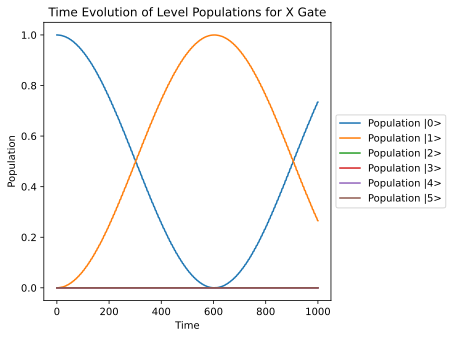

In [688]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Time Evolution of Level Populations for X Gate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [689]:
d01 = abs(n_op_energy_basis[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

603.6757989431644

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

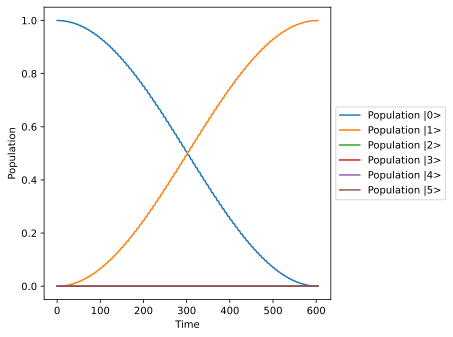

In [690]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Fidelity

In [691]:
X_ideal = qt.sigmax()

X_ideal

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [692]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.10388939e-02+2.58298502e-04j  2.12029444e-01-9.77181428e-01j
  -3.55562451e-03-2.26581256e-03j  4.43756408e-03-2.53185827e-04j
  -4.21274837e-04-1.54520588e-04j -5.41414857e-04-7.65990721e-05j]
 [ 3.06916619e-01+9.51645066e-01j -1.09388536e-02+1.35107792e-03j
  -6.07819226e-03+3.39692808e-03j -1.79052499e-03+7.05867165e-04j
   2.60712331e-04-2.96064379e-04j -1.02224109e-04+7.81803276e-05j]
 [-6.25771344e-03+2.95530038e-03j  2.33098707e-03-3.58717433e-03j
   5.91680972e-01+8.05892495e-01j -7.07964539e-04-6.15749526e-03j
   7.88214164e-04-6.08684498e-04j -7.57601569e-04+2.85711469e-04j]
 [-1.93115241e-03+3.25949665e-04j -4.43757145e-03-1.47660304e-04j
   4.28107607e-03+4.45577179e-03j  2.47670253e-01+9.67771916e-01j
   1.54282189e-02-8.77512390e-03j  1.10336176e-02-1.64749213e-03j]
 [-3.94962341e-04+8.38839357e-05j -2.84865749e-04+3.19837982e-04j
  -6.96730912e-04+7.96679702e-04j -1.500

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16

Calculating propagators...


Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 24034.02it/s]


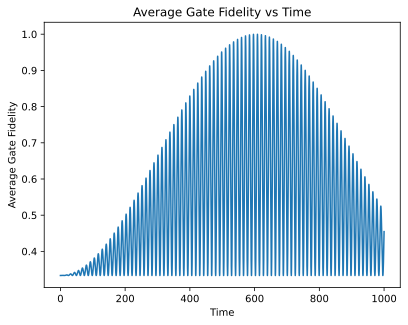

In [693]:
iterations = 10000

options = qt.Options(nsteps=1000000, store_states=True, atol=1e-12, rtol=1e-11)

print("Calculating propagators...")
P_list = qt.propagator(H, times, args=args, options=options)

fid_times = []
fid_values = []
for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = P_list[i]
    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [694]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

tx = peak_time

Peak average gate fidelity: 0.9997029388439721
Time at peak fidelity: 608.7608760876087


---------------------

## Noise

### Defining gamma

In [695]:
gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5)
        if t1 is not None and t1 > 0:
            rate = 1.0 / t1
            gamma_ij[(i, j)] = rate
            # gamma_ij[(j, i)] = rate  
gamma_ij

{(0, 1): 1.0105150256036662e-05,
 (0, 2): 0.00012457805723540096,
 (1, 2): 0.0005778185878582614,
 (0, 3): 0.00043847193831442877,
 (1, 3): 9.674498864173898e-05,
 (2, 3): 0.0003654648737811229,
 (0, 4): 4.5358716542010955e-08,
 (1, 4): 1.373715093941894e-05,
 (2, 4): 4.647618634468422e-06,
 (3, 4): 0.0005689889229704481,
 (0, 5): 9.935607252458312e-06,
 (1, 5): 4.8612641906153375e-06,
 (2, 5): 3.903431069544427e-06,
 (3, 5): 0.00028623658100727125,
 (4, 5): 0.00016702026913130086}

### Defining c_ops

In [696]:
c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

# c_ops

### Calculating the list of propagators

In [697]:
# times = np.linspace(0, 1000, iterations)

print("Calculating propagators...")
P_list = qt.propagator(H, times, c_ops=c_ops, args=args, options=options)

# P_list

Calculating propagators...


In [698]:
p_unitary = []

for i in range (len(P_list)):

    p_special = P_list[i]

    P_kraus_special = qt.to_kraus(p_special)

    p_special_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in P_kraus_special]

    p_special_2x2_super = qt.kraus_to_super(p_special_2x2)

    p_unitary.append(p_special_2x2_super)

Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 13320.46it/s]


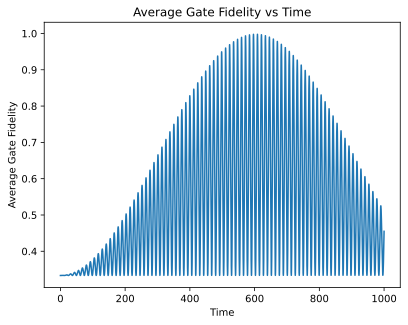

In [699]:
fid_times = []
fid_values = []

for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    # U_t = P_list[i]

    #testing
    fid = qt.average_gate_fidelity(p_unitary[i], X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [700]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

Peak average gate fidelity: 0.9976558286658328
Time at peak fidelity: 608.7608760876087


-----------------

In [701]:
p_special = P_list[6000]

p_special

Quantum object: dims=[[[6], [6]], [[6], [6]]], shape=(36, 36), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 2.45965471e-03+7.05731607e-16j -1.06657080e-02-7.18771794e-03j
  -2.82260658e-05-3.59346017e-04j ...  1.85131017e-06+6.47813357e-04j
   5.81968843e-05-2.40197126e-04j  1.86113091e-02-1.50061006e-17j]
 [-3.88618938e-03+1.39913867e-02j  4.04064331e-05+8.38515473e-04j
  -2.03417273e-04+1.39988699e-05j ... -2.19047865e-04+5.57329120e-05j
   2.59025199e-05-1.71219295e-05j  1.17323075e-03+4.80298615e-03j]
 [-3.41382567e-05-3.09111297e-05j  3.03417637e-05+5.20601701e-05j
  -8.68589923e-03+6.93210214e-03j ...  7.85651216e-07-2.49692229e-06j
   3.54919466e-09-1.70193013e-08j -6.65315173e-06-1.71132142e-06j]
 ...
 [ 6.42946654e-07+2.62620131e-07j  5.43773489e-07+2.74670173e-07j
  -3.33759125e-06-1.08173665e-06j ...  4.95060947e-01+4.39258851e-01j
   2.44215489e-03-4.59562590e-03j  2.84906635e-03-2.00748065e-03j]
 [ 2.48342412e-09+2.92328839e-08j  1.98662377e-09-1.08590911e-07j
  

----------------

In [702]:
p_special = P_list[6000]

P_kraus_special = qt.to_kraus(p_special)


In [703]:
P_kraus_special = qt.to_kraus(p_special)

P_kraus_special

[Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[-2.43104252e-10-0.00000000e+00j -1.69489603e-10-2.19528501e-11j
   -1.90002260e-13+3.54145868e-13j  4.48110009e-14-1.10233798e-12j
   -1.30141453e-14+8.07815155e-14j -7.01324802e-15-4.30852104e-14j]
  [-3.85743320e-09-2.29802701e-09j -3.73717300e-09-1.63318564e-09j
   -3.11526842e-12+1.09300149e-11j  1.04556028e-11-1.91435835e-11j
   -8.30943583e-13+1.72386304e-12j  3.47168447e-13-4.23825148e-13j]
  [-5.37627246e-09-2.32470223e-09j -5.01823510e-09-1.60457716e-09j
   -2.34950849e-12+1.46400739e-11j  1.05432630e-11-2.63912689e-11j
   -8.40997179e-13+2.32918060e-12j  3.48798631e-13-6.31855248e-13j]
  [-1.05789152e-07-2.85433914e-08j -9.87498380e-08-1.44421927e-08j
   -8.11314411e-12+2.71192132e-10j  1.20545524e-10-5.21047979e-10j
   -8.50962069e-12+4.60757719e-11j  5.17898087e-12-1.22150948e-11j]
  [-2.47938253e-05+3.24547218e-05j -1.89508916e-05+3.17119591e-05j
    9.37045032e-08+4.1637

In [704]:
#WRONG!

p_special_2x2 = qt.Qobj(P_kraus_special[0].full()[:2, :2])

p_special_2x2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-2.43104252e-10-0.00000000e+00j -1.69489603e-10-2.19528501e-11j]
 [-3.85743320e-09-2.29802701e-09j -3.73717300e-09-1.63318564e-09j]]

In [705]:
p_special_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in P_kraus_special]

p_special_2x2

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[-2.43104252e-10-0.00000000e+00j -1.69489603e-10-2.19528501e-11j]
  [-3.85743320e-09-2.29802701e-09j -3.73717300e-09-1.63318564e-09j]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[-2.75781219e-10-0.00000000e+00j  1.72944135e-10+3.48669220e-11j]
  [-3.52273330e-09-3.62185900e-09j  4.41469706e-09+3.47872657e-09j]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[-1.86791452e-11-0.00000000e+00j  4.72865026e-10-3.64424350e-10j]
  [-4.58716522e-10-3.19709178e-10j -4.12139060e-11-3.50048929e-11j]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[ 7.21345028e-08+0.00000000e+00j -8.48843830e-08-4.59314682e-09j]
  [ 3.51446987e-08-2.21545912e-10j -4.09923243e-08-1.89002502e-09j]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), 

In [706]:
p_special_2x2_super = qt.kraus_to_super(p_special_2x2)

p_special_2x2_super

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 2.45965471e-03+0.00000000e+00j -1.06657080e-02-7.18771794e-03j
  -1.06657080e-02+7.18771794e-03j  9.97561993e-01+0.00000000e+00j]
 [-3.88618938e-03+1.39913867e-02j  4.04064331e-05+8.38515473e-04j
  -2.45568901e-01-9.65263906e-01j  4.80163526e-03-1.02399281e-02j]
 [-3.88618938e-03-1.39913867e-02j -2.45568901e-01+9.65263906e-01j
   4.04064331e-05-8.38515473e-04j  4.80163526e-03+1.02399281e-02j]
 [ 9.97521830e-01+0.00000000e+00j  1.06740400e-02+7.19163139e-03j
   1.06740400e-02-7.19163139e-03j  2.41241837e-03+0.00000000e+00j]]

In [707]:
fidelity_special = qt.average_gate_fidelity(p_special_2x2_super, X_ideal)

fidelity_special

0.5839910035636356